In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skend\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Reading and Preparing the dataset**

In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['Category', 'Message']

In [3]:
df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df.shape

(5572, 2)

In [5]:
df.describe

<bound method NDFrame.describe of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham              Will Ì_ b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [6]:
df.drop_duplicates(subset=['Category', 'Message'], keep='first', inplace=True)
df.dropna(inplace=True)

**Visualizing data distribution**

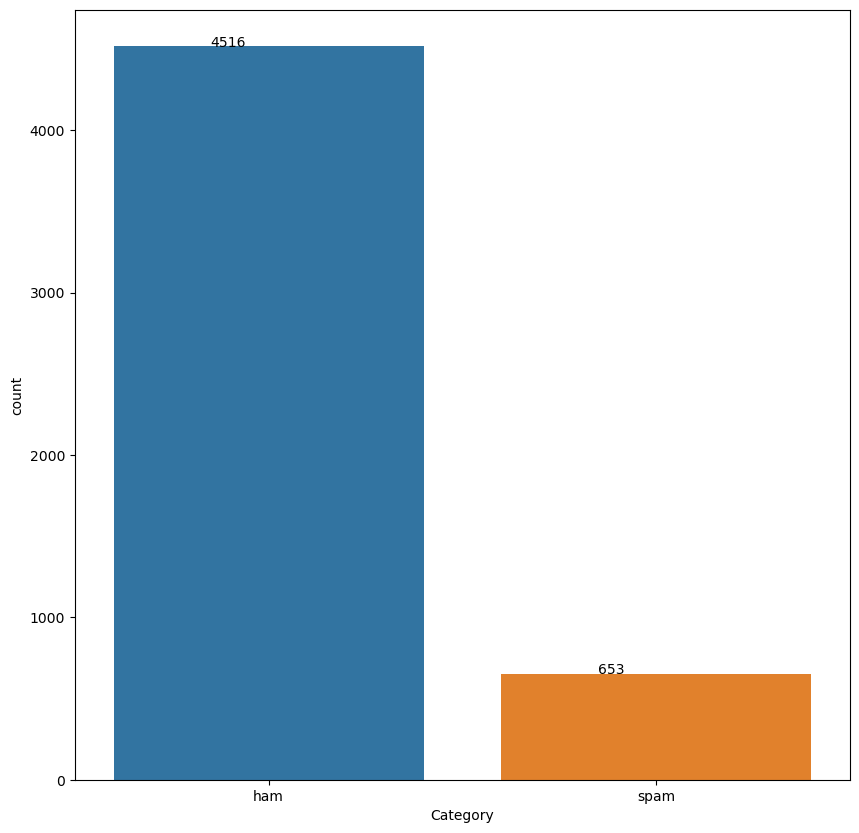

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.countplot(x=df["Category"], data=df)
for p, label in zip(ax.patches, df["Category"].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5))
plt.show()

**Text Preprocessing: Converting to Lowercase and Removing Punctuation**

In [8]:
df["Message"] = df["Message"].str.lower()
df["Message"] = df["Message"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
print(df["Message"])

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ì_ b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: Message, Length: 5169, dtype: object


**Tokenizing the Messages**

In [9]:
df["Message"] = df["Message"].apply(word_tokenize)
print(df["Message"])

0       [go, until, jurong, point, crazy, available, o...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, in, 2, a, wkly, comp, to, win, f...
3       [u, dun, say, so, early, hor, u, c, already, t...
4       [nah, i, dont, think, he, goes, to, usf, he, l...
                              ...                        
5567    [this, is, the, 2nd, time, we, have, tried, 2,...
5568        [will, ì_, b, going, to, esplanade, fr, home]
5569    [pity, was, in, mood, for, that, soany, other,...
5570    [the, guy, did, some, bitching, but, i, acted,...
5571                     [rofl, its, true, to, its, name]
Name: Message, Length: 5169, dtype: object


**Removing Stop Words**

In [10]:
stop_words = set(stopwords.words("english"))
df["Message"] = df["Message"].apply(lambda x: [word for word in x if word not in stop_words])
print(df["Message"])

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, u, å750, pou...
5568                  [ì_, b, going, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [rofl, true, name]
Name: Message, Length: 5169, dtype: object


**Stemming Words**

In [11]:
ps = PorterStemmer()
df["Message"] = df["Message"].apply(lambda x: [ps.stem(word) for word in x])
print(df["Message"])

0       [go, jurong, point, crazi, avail, bugi, n, gre...
1                            [ok, lar, joke, wif, u, oni]
2       [free, entri, 2, wkli, comp, win, fa, cup, fin...
3           [u, dun, say, earli, hor, u, c, alreadi, say]
4       [nah, dont, think, goe, usf, live, around, tho...
                              ...                        
5567    [2nd, time, tri, 2, contact, u, u, å750, pound...
5568                      [ì_, b, go, esplanad, fr, home]
5569                         [piti, mood, soani, suggest]
5570    [guy, bitch, act, like, id, interest, buy, som...
5571                                   [rofl, true, name]
Name: Message, Length: 5169, dtype: object


**Joining Tokenized Words**

In [12]:
df["Message"] = df["Message"].apply(lambda x: " ".join(x))
print(df["Message"])

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4               nah dont think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u u å750 pound prize 2 ...
5568                             ì_ b go esplanad fr home
5569                              piti mood soani suggest
5570    guy bitch act like id interest buy someth els ...
5571                                       rofl true name
Name: Message, Length: 5169, dtype: object


**Calculating Frequency Distribution of Unigrams**

In [13]:
tokenized_text = " ".join(df["Message"].tolist())
fdist = FreqDist(nltk.word_tokenize(tokenized_text))
top_unigrams = fdist.most_common(10)
print(top_unigrams)

[('u', 1001), ('call', 553), ('im', 448), ('2', 443), ('go', 434), ('get', 425), ('ur', 316), ('come', 277), ('dont', 258), ('4', 257)]


**Visualizing the Most Frequent Words and Unigrams**

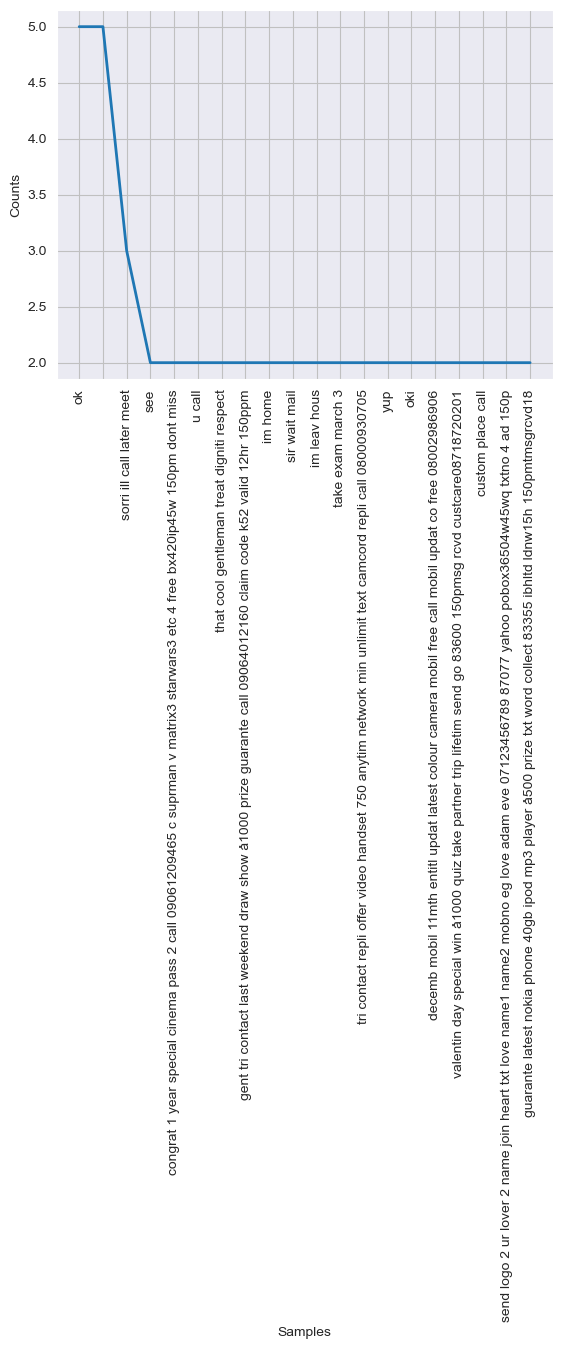

<Axes: xlabel='Samples', ylabel='Counts'>

In [14]:
sns.set_style('darkgrid')
nlp_words = FreqDist(df["Message"])
nlp_words.plot(20)

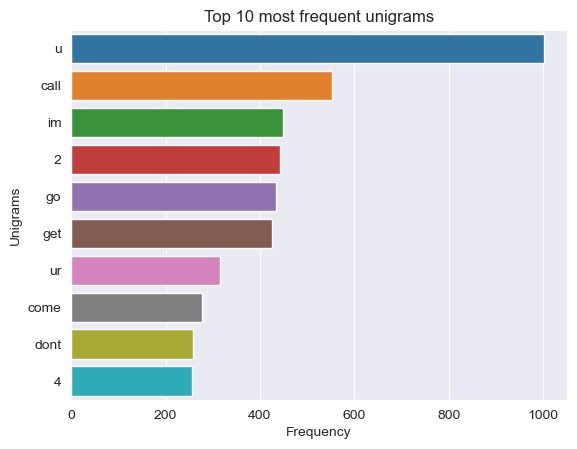

In [15]:
sns.barplot(x=[x[1] for x in top_unigrams], y=[x[0] for x in top_unigrams])
plt.title("Top 10 most frequent unigrams")
plt.xlabel("Frequency")
plt.ylabel("Unigrams")
plt.show()

**Splitting the Dataset into Training and Testing Sets**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state=42)

**Creating TF-IDF Vectors**

In [17]:
tfidf_vector = TfidfVectorizer()
tfidf_vector.fit(X_train)
train_tfidf = tfidf_vector.transform(X_train)
test_tfidf = tfidf_vector.transform(X_test)
train_tfidf.shape

(4135, 7034)

**Normalizing TF-IDF Vectors**

In [18]:
normalizer = preprocessing.Normalizer()
normalizer.fit(train_tfidf)
train_tfidf = normalizer.transform(train_tfidf)
test_tfidf = normalizer.transform(test_tfidf)
print(train_tfidf.shape)

(4135, 7034)


**Encoding the Target Variable**

In [19]:
le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

**Training the K-Nearest Neighbors Classifier**

In [20]:
clf = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
clf.fit(train_tfidf, y_train_encoded)

KNeighborsClassifier(metric='cosine', weights='distance')

**Evaluating the K-Nearest Neighbors Classifier**

In [21]:
y_predict_test = clf.predict(test_tfidf)
test_auc = roc_auc_score(y_test_encoded, y_predict_test)
print("K-Nearest Neighbors Test AUC =", test_auc)

K-Nearest Neighbors Test AUC = 0.8747372095729413


In [22]:
precision_knn = precision_score(y_test_encoded, y_predict_test)
recall_knn = recall_score(y_test_encoded, y_predict_test)
f1_knn = f1_score(y_test_encoded, y_predict_test)
print("K-Nearest Neighbors Precision =", precision_knn)
print("K-Nearest Neighbors Recall =", recall_knn)
print("K-Nearest Neighbors F1-score =", f1_knn)

K-Nearest Neighbors Precision = 0.9819819819819819
K-Nearest Neighbors Recall = 0.7517241379310344
K-Nearest Neighbors F1-score = 0.8515624999999999


**Plotting the Confusion Matrix for KNN**

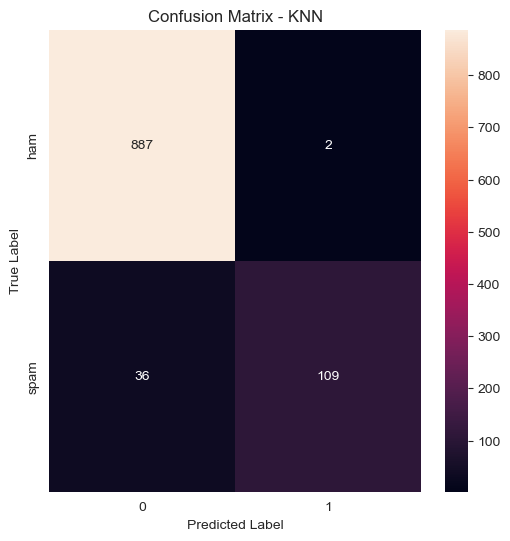

In [23]:
plt.figure(figsize=(6, 6))
sns.heatmap(pd.crosstab(y_test, y_predict_test), annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - KNN")
plt.show()

**Tokenizing and Padding the Text Sequences**

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(text.split()) for text in X_train])

In [25]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [33]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

**Creating and Training the LSTM Model**

In [27]:
embedding_dim = 100

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_padded, y_train_encoded, validation_data=(X_test_padded, y_test_encoded), epochs=10, batch_size=32)
y_predict_test_lstm = model.predict(X_test_padded)
test_auc_lstm = roc_auc_score(y_test_encoded, y_predict_test_lstm)
print("LSTM Test AUC =", test_auc_lstm)

Epoch 1/10
130/130 [==============================] - 23s 138ms/step - loss: 0.2123 - accuracy: 0.9333 - val_loss: 0.0796 - val_accuracy: 0.9768
Epoch 2/10
130/130 [==============================] - 16s 127ms/step - loss: 0.0366 - accuracy: 0.9886 - val_loss: 0.0696 - val_accuracy: 0.9807
Epoch 3/10
130/130 [==============================] - 17s 129ms/step - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0983 - val_accuracy: 0.9797
Epoch 4/10
130/130 [==============================] - 16s 124ms/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.0845 - val_accuracy: 0.9836
Epoch 5/10
130/130 [==============================] - 16s 123ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0802 - val_accuracy: 0.9836
Epoch 6/10
130/130 [==============================] - 16s 126ms/step - loss: 7.5491e-04 - accuracy: 1.0000 - val_loss: 0.0964 - val_accuracy: 0.9816
Epoch 7/10
130/130 [==============================] - 16s 126ms/step - loss: 3.5982e-04 - accuracy: 1.0000 - val_loss: 0.1136 

**Convert predictions to string format**

In [30]:
y_predict_test_lstm_str = []
for y_pred in y_predict_test_lstm.round():
    y_predict_test_lstm_str.append(str(int(y_pred)))

**Create a DataFrame with the test labels and predictions**

In [31]:
df_confusion = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_predict_test_lstm_str})

**Plot the confusion matrix**

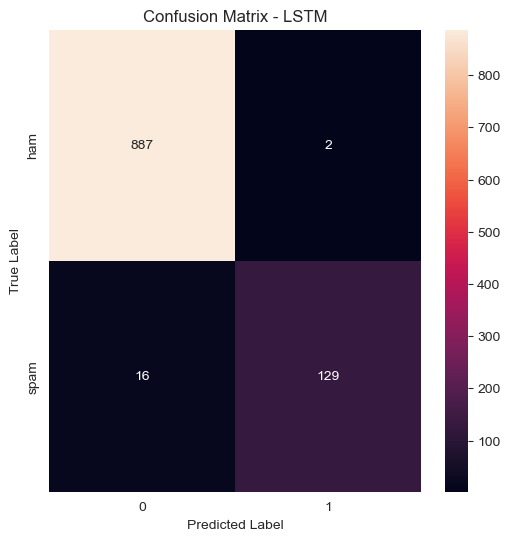

In [32]:
plt.figure(figsize=(6, 6))
sns.heatmap(pd.crosstab(df_confusion['True Label'], df_confusion['Predicted Label']), annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()